In [1]:
print "Stock Prediction using Lstm <Historical Stock data,Semantic score>"

Stock Prediction using Lstm <Historical Stock data,Semantic score>


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import datetime

In [19]:
def get_stock_data(stock_name,market_name,normalized=0):
    #getting todays date
    today=datetime.datetime.now()
    #dictionary for the months for Google Finance API
    month={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    #https://finance.google.com/finance/historical?q=NASDAQ:AAPL&num=30&ei=-8_DWfi2NMOYuQSr3424BA&startdate=Sep+21%2C+2014&enddate=Sep+21%2C+2017&output=csv
    url="https://finance.google.com/finance/historical?q="+market_name+":"+stock_name+"&num=30&ei=-8_DWfi2NMOYuQSr3424BA"+"&startdate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year-2)+"&enddate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year)+"&output=csv"
    
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(url,header=0, names=col_names)
    
    df_stocks= pd.DataFrame(stocks)
    
    sem_cols=['Date','Semantic']
    semantic=pd.read_csv('/home/siddharth/Desktop/StockPrediction/semantic/semantic.csv',header=0,names=sem_cols)
    df_semantics=pd.DataFrame(semantic)
    df=pd.merge(semantic,stocks,how='inner',left_on=None, right_on=None)
    df=df[::-1]
    df_date=df.copy()
    df.drop(df.columns[[0,4,6]], axis=1, inplace=True)
    df_date.drop(df_date.columns[[4,6]], axis=1, inplace=True)
    columns=['Open','High','Close']
    df[columns] = df[columns].convert_objects(convert_numeric=True)
    df[columns] = df[columns].astype('float64')
    print df.dtypes
    return df,df_date

In [20]:
stock_name = 'INFY'
market_name= 'NYSE'
df,df_date= get_stock_data(stock_name,market_name,0)
print "df---------------------------"
print df.tail()
print "df with date-----------------"
print df_date.tail()

Semantic    float64
Open        float64
High        float64
Close       float64
dtype: object
df---------------------------
   Semantic   Open   High  Close
4       0.0  17.50  18.07  18.04
3       0.0  17.40  17.46  17.45
2       0.0  17.69  17.80  17.40
1       0.0  17.78  17.78  17.53
0       0.0  18.68  19.03  17.88
df with date-----------------
        Date  Semantic   Open   High  Close
4  16-Oct-15       0.0  17.50  18.07  18.04
3  15-Oct-15       0.0  17.40  17.46  17.45
2  14-Oct-15       0.0  17.69  17.80  17.40
1  13-Oct-15       0.0  17.78  17.78  17.53
0  12-Oct-15       0.0  18.68  19.03  17.88


/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [21]:
maxhigh=max(df['High'])
maxclose=max(df['Close'])
maxopen=max(df['Open'])
df['High']=df['High']/max(df['High'])
df['Close']=df['Close']/max(df['Close'])
df['Open']=df['Open']/max(df['Open'])
print df

     Semantic      Open      High   Close
354  0.000000  0.726487  0.716659  0.7295
353  0.000000  0.726487  0.699072  0.7135
352  0.000000  0.727504  0.701514  0.7150
351  0.129000  0.734113  0.706400  0.7170
350 -0.160000  0.738180  0.711773  0.7155
349  0.118000  0.740214  0.713239  0.7295
348  0.000000  0.749873  0.721544  0.7320
347  0.000000  0.750381  0.729360  0.7420
346  0.194750  0.755465  0.725940  0.7400
345  0.127667  0.752923  0.723986  0.7400
344  0.264000  0.747839  0.720078  0.7325
343  0.013000  0.738688  0.714216  0.7275
342  0.076000  0.738180  0.710308  0.7265
341 -0.030250  0.739197  0.713239  0.7270
340  0.172000  0.738688  0.716659  0.7285
339  0.000000  0.762583  0.735222  0.7500
338  0.000000  0.772242  0.744016  0.7525
337  0.000000  0.772242  0.747924  0.7635
336  0.000000  0.781393  0.754763  0.7655
335  0.000000  0.765125  0.741573  0.7575
334  0.000000  0.758516  0.734734  0.7495
333  0.000000  0.739197  0.725940  0.7410
332  0.000000  0.729029  0.702491 

In [22]:
def model_data(stock,seq_len):
    features=len(stock.columns)
    data=stock.as_matrix()
    print data

In [23]:
#main lstm !--! Yo ready for work
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [24]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [25]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (314, 5, 4))
('y_train', (314,))
('X_test', (35, 5, 4))
('y_test', (35,))


In [26]:
model = build_model2([4,window,1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`


In [27]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: nan MSE (nan RMSE)


In [28]:
diff=[]
ratio=[]
p = model.predict(X_test)
print "index","    actual        ","predicted     ","error          ","   difference       "
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    k=((y_test[u]/pr)-1)*100
    print(u, y_test[u], pr, k, abs(y_test[u]- pr))

index     actual         predicted      error              difference       
(0, 0.79049999999999998, 0.78226435, 1.0527960446862439, 0.0082356481552123828)
(1, 0.79549999999999998, 0.78264505, 1.6425010728751577, 0.012854953289031967)
(2, 0.77949999999999997, 0.78570825, -0.7901468040085291, 0.0062082486152649219)
(3, 0.78550000000000009, 0.78941059, -0.495381132385464, 0.0039105911254881942)
(4, 0.79000000000000004, 0.79156369, -0.19754439586346928, 0.0015636897087096813)
(5, 0.76600000000000001, nan, nan, nan)
(6, 0.77449999999999997, nan, nan, nan)
(7, 0.77350000000000008, nan, nan, nan)
(8, 0.77449999999999997, nan, nan, nan)
(9, 0.78249999999999997, nan, nan, nan)
(10, 0.79649999999999999, 0.78020233, 2.0889031257813828, 0.016297670841217027)
(11, 0.73949999999999994, 0.78190178, -5.4229032404377708, 0.042401776790618961)
(12, 0.72799999999999998, 0.78656775, -7.4459889529104757, 0.058567747592926045)
(13, 0.71299999999999997, 0.78720695, -9.4266124061218157, 0.074206947803497347

In [29]:
#size=len(ratio)
#error=sum(ratio)/size
total=0;
ct=0;
for g in ratio:
    if not math.isnan(g):
        total=total+g
        ct=ct+1
error=total/ct        
print "average error rate :",abs(error*100)

average error rate : 0.413229566802


INFY 2017-10-04 20:35:49.379674


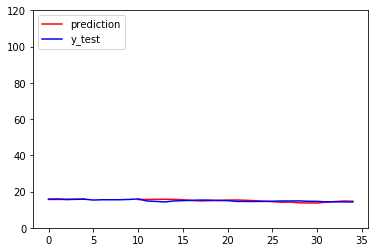

In [30]:
import matplotlib.pyplot as plt2
print stock_name,datetime.datetime.now()
plt2.plot(p*maxclose,color='red', label='prediction')
plt2.plot(y_test*maxclose,color='blue', label='y_test')
plt2.ylim([0,maxclose+100])
plt2.legend(loc='upper left')
plt2.show()

In [31]:
#nice

In [32]:
 print "next time"

next time
